## Saving a Cats v Dogs Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it so you can use it in your app.

In [1]:
# Make sure we've got the latest version of fastai:
!pip install -Uqq fastai
!pip install -Uqq duckduckgo_search

First, import all the stuff we need from fastai:

In [2]:
from fastai.vision.all import *
from fastcore.all import *
moods  = 'happy','sad', 'annoyed'

from pathlib import Path
path = Path('faces')


Download and decompress our dataset, which is pictures of dogs and cats:

In [3]:
from duckduckgo_search import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=40): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

In [4]:
from time import sleep

for o in moods:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'human {o} face photo', max_images=100))
        resize_images(path/o, max_size=400, dest=path/o)
        sleep(10)  # Pause between searches to avoid over-loading server


/home/vscode/.local/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

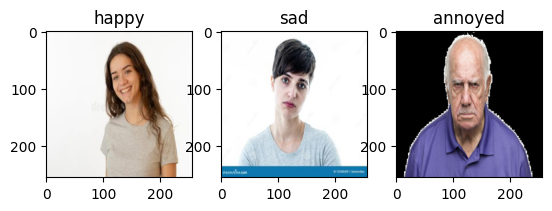

In [ ]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np

to_display = []
for idx, o in enumerate(moods):
    p = path.absolute().__str__() + "/" + o
    file = [f for f in listdir(p) if isfile(join(p,f))][0]
    dest = join(p, file)
    im = Image.open(dest)
    im = im.resize((256,256))
    to_display.append(im)
    plt.subplot(1, 3, idx+1)
    plt.imshow(np.array(im))
    plt.title(o)


In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

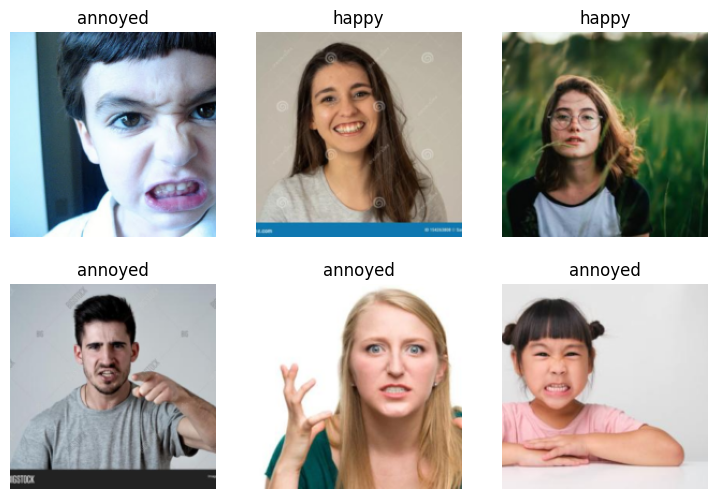

In [ ]:
def my_get_img(path):
    return get_image_files(f"{path}/happy") + get_image_files(f"{path}/annoyed")

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=my_get_img, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(192)
    #,batch_tfms=aug_transforms()
).dataloaders(path)

dls.show_batch(max_n=6)

... and train our model, a resnet18 (to keep it small and fast):

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.193042,1.025515,0.416667,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.852267,0.828494,0.333333,00:03
1,0.680121,0.810577,0.388889,00:03
2,0.566587,0.778932,0.388889,00:02
3,0.475965,0.765304,0.305556,00:03
4,0.406737,0.784711,0.333333,00:02
5,0.351187,0.774057,0.305556,00:02
6,0.308642,0.749846,0.277778,00:02
7,0.270114,0.718692,0.250000,00:02


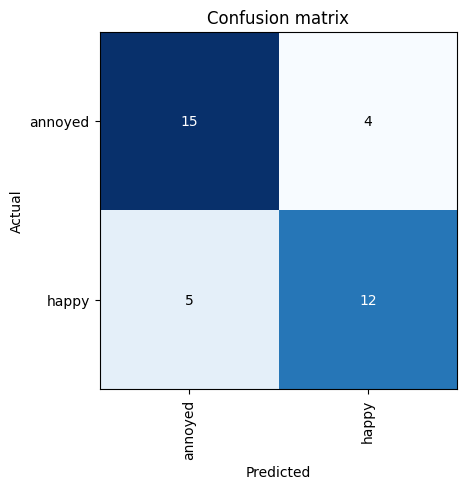

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


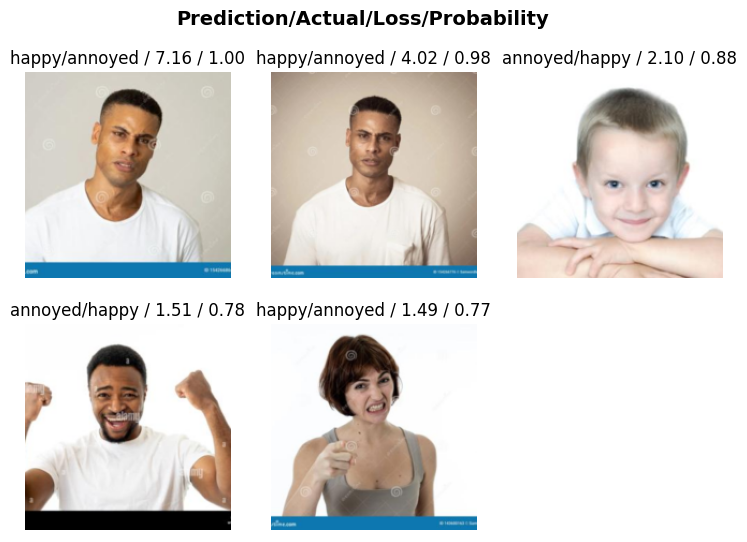

In [ ]:
interp.plot_top_losses(5, nrows=2)

In [ ]:
#hide_output
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

No such comm: cf77ee3b0388464996275dc555ab6859
No such comm: bbacdab2366f4518944b514d1290eaad


In [ ]:
print(len(cleaner.delete()))
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
print(len(cleaner.change()))
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

0
0


True


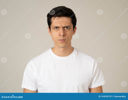

In [ ]:
from fastdownload import download_url
url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fthumbs.dreamstime.com%2Fz%2Fportrait-handsome-young-man-angry-face-looking-disgusted-human-expressions-emotions-close-up-caucasian-male-144539193.jpg&f=1&nofb=1&ipt=7dc48b6c0f8f7af2736c76eb150da2d43a8cbd4313431df0d5a48b6acd0c37d5&ipo=images"
dest = 'images/test.jpg'
download_url(url, dest)
print(verify_image(dest))
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
print(learn.predict(im))
pred,pred_idx,probs = learn.predict(im)


NameError: name 'learn' is not defined

Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [ ]:
learn.export('model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.